# Autonomous and Adaptive Systems Project
The followong code shows the implemetation of a PPO agent.
The evaluation on the three defferent games has been carried out in three different run to ease the computation and time limitations. In this case the agent is trained and evaluated on the Caveflyer environment

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow.keras import layers, Model
import gym
import procgen
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import os
from tqdm import tqdm
import json
from ppoagent import PPOAgent
from impala_network import PolicyNetwork, ValueNetwork
from randomagent import RandomAgent
from utilities import plot_test_and_rnd_rewards, plot_test_and_rnd_ep_length, plot_avg_reward, plot_avg_ep_length

In [2]:
TRAIN_AGENT = True
SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
SAVE_TRAIN_LISTS = True

RENDER_GAME = False
RENDER_RND_GAME = False

N_TIMESTEP_TRAIN = 200000
N_EPISODES_TEST = 200
WINDOW_WIDTH = 50
NORMALIZE_REWARDS = [True,(3.5,12)]


GAMES = ['caveflyer']
TEST_GAME = 'caveflyer'
START_LEVEL = 0
NUM_LEVELS = 200
SEED = 1
SEEDS_TEST = [1, 40, 99]
DIFFICULTY = 'easy'
BACKGROUND = True
MODE = 'generalization'

weights_directory = './ppo_'+ GAMES[0] +'_200k_Final'

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Creation of the different environments 

In [3]:

if MODE == 'sample_efficiency':
    train_envs = [
        gym.make(
            'procgen:procgen-' + game + '-v0',
            num_levels=0,
            rand_seed= SEED,
            distribution_mode=DIFFICULTY,
            use_backgrounds=BACKGROUND
        )
        for game in GAMES
    ]
elif MODE == 'generalization':
    train_envs = [
        gym.make(
            'procgen:procgen-' + game + '-v0',
            num_levels=NUM_LEVELS, 
            rand_seed = SEED,
            start_level=START_LEVEL,
            distribution_mode=DIFFICULTY,
            use_backgrounds=BACKGROUND
        )
        for game in GAMES
    ]

test_envs = [
    gym.make(
        'procgen:procgen-' + TEST_GAME + '-v0',
        num_levels=0, 
        rand_seed= seed_test,
        distribution_mode=DIFFICULTY,
        use_backgrounds=BACKGROUND,
        render='human' if RENDER_GAME else None
    )
    for seed_test in SEEDS_TEST
]

test_envs_rnd = [
    gym.make(
        'procgen:procgen-' + TEST_GAME + '-v0',
        num_levels=0, 
        rand_seed= seed_test,
        distribution_mode=DIFFICULTY,
        use_backgrounds=BACKGROUND,
        render='human' if RENDER_RND_GAME else None
    )
    for seed_test in SEEDS_TEST
]


### Training Process

In [5]:
input_shape = train_envs[0].observation_space.shape
action_space = train_envs[0].action_space.n

policy_net = PolicyNetwork(input_shape, action_space)
value_net = ValueNetwork(input_shape)

ppo_agent = PPOAgent(train_envs, policy_net, value_net)

In [6]:
if LOAD_WEIGHTS:
    ppo_agent.load_models(weights_directory)

if TRAIN_AGENT:
    train_rewards, train_episode_lengths = ppo_agent.train(max_timesteps=N_TIMESTEP_TRAIN, normalize_rewards=NORMALIZE_REWARDS)
    if SAVE_WEIGHTS:
        ppo_agent.save_models(weights_directory)

Training Progress:   0%|          | 0/200000 [00:00<?, ? timestep/s]c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\giaco\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarra

Models saved to ./ppo_caveflyer_200k_Final


The lists containing the trainig rewards and episode lengths are stores if needed for a comparison

In [7]:
if TRAIN_AGENT and SAVE_TRAIN_LISTS:
    with open(GAMES[0]+'_reward_0to200k.json', 'w') as file:
        json.dump(train_rewards, file)
    with open(GAMES[0]+'_ep_len_0to200k.json', 'w') as file:
        json.dump(train_rewards, file)
    print('Training results saved')

Training results saved


In [8]:
if TRAIN_AGENT:
    for i, game in enumerate(GAMES):
        avg_reward_train = sum(train_rewards[i])/len(train_rewards[i])
        avg_episode_lenght = sum(train_episode_lengths[i])/len(train_episode_lengths[i])
        game = game.upper()
        print(game, ' - Average reward during training: ', avg_reward_train)
        print('\t Average episode lenght during training: ', avg_episode_lenght)

CAVEFLYER  - Average reward during training:  -186.88945464290668
	 Average episode lenght during training:  454.73348519362185


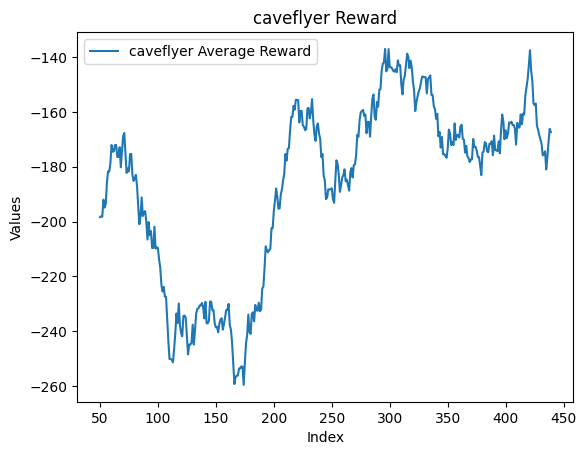

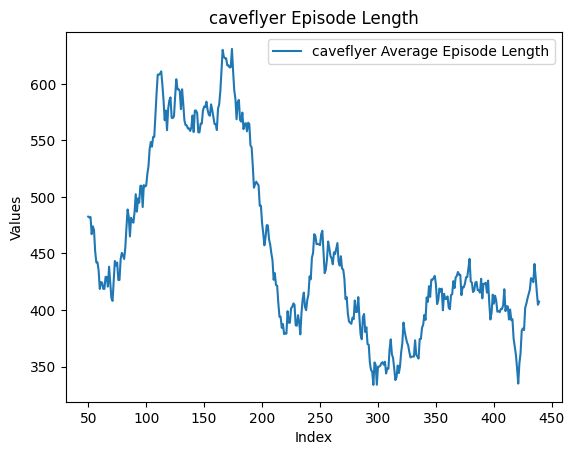

In [9]:
if TRAIN_AGENT:
    plot_avg_reward(train_rewards, GAMES, window_width= WINDOW_WIDTH)
    plot_avg_ep_length(train_episode_lengths, GAMES, window_width= WINDOW_WIDTH)

### Evaluation Process

In [10]:
test_rewards, test_episode_lengths = ppo_agent.test(test_envs, num_episodes=N_EPISODES_TEST)

Testing Progress: 100%|██████████| 600/600 [3:05:08<00:00, 18.51s/episode]  


In [11]:
random_agent = RandomAgent(test_envs_rnd)
random_rewards, random_episode_lengths = random_agent.test(test_envs_rnd, num_episodes=N_EPISODES_TEST)

Testing Progress: 100%|██████████| 600/600 [00:54<00:00, 10.96 episode/s]


In [12]:
array_of_test_rewards = np.array(test_rewards)
avg_of_test_rewards_per_seed = np.mean(array_of_test_rewards, axis=1)

test_reward_average = np.mean(avg_of_test_rewards_per_seed)
test_reward_std_dev = np.std(avg_of_test_rewards_per_seed)

print('Average reward during testing: ', test_reward_average)
print('Standard deviation: ', test_reward_std_dev)

array_of_test_episode_lengths = np.array(test_episode_lengths)
avg_of_test_episode_lengths_per_seed = np.mean(array_of_test_episode_lengths, axis=1)

test_episode_length_average = np.mean(avg_of_test_episode_lengths_per_seed)
test_episode_length_std_dev = np.std(avg_of_test_episode_lengths_per_seed)

print('Average episode length during testing: ', test_episode_length_average)
print('Standard deviation: ', test_episode_length_std_dev)

Average reward during testing:  3.5
Standard deviation:  0.2273030282830975
Average episode length during testing:  373.68499999999995
Standard deviation:  17.460813268573702


In [14]:
array_of_rnd_rewards = np.array(random_rewards)
avg_of_rnd_rewards_per_seed = np.mean(array_of_rnd_rewards, axis=1)

rnd_reward_average = np.mean(avg_of_rnd_rewards_per_seed)
rnd_reward_std_dev = np.std(avg_of_rnd_rewards_per_seed)

print('Average reward during testing - Random agent: ', rnd_reward_average)
print('Standard deviation - Random agent: ', rnd_reward_std_dev)

array_of_rnd_episode_lengths = np.array(random_episode_lengths)
avg_of_rnd_episode_lengths_per_seed = np.mean(array_of_rnd_episode_lengths, axis=1)

rnd_episode_length_average = np.mean(avg_of_rnd_episode_lengths_per_seed)
rnd_episode_length_std_dev = np.std(avg_of_rnd_episode_lengths_per_seed)

print('Average episode length during testing - Random agent: ', rnd_episode_length_average)
print('Standard deviation - Random agent: ', rnd_episode_length_std_dev)

Average reward during testing - Random agent:  2.643333333333333
Standard deviation - Random agent:  0.09877021593352697
Average episode length during testing - Random agent:  515.2816666666666
Standard deviation - Random agent:  25.87184645302473


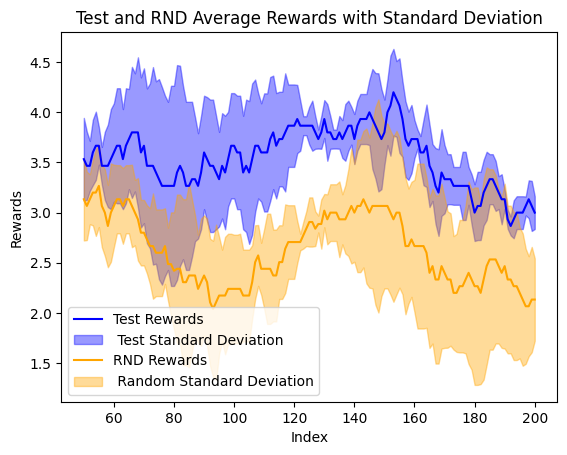

In [15]:
plot_test_and_rnd_rewards(test_rewards, random_rewards, window_width= WINDOW_WIDTH)

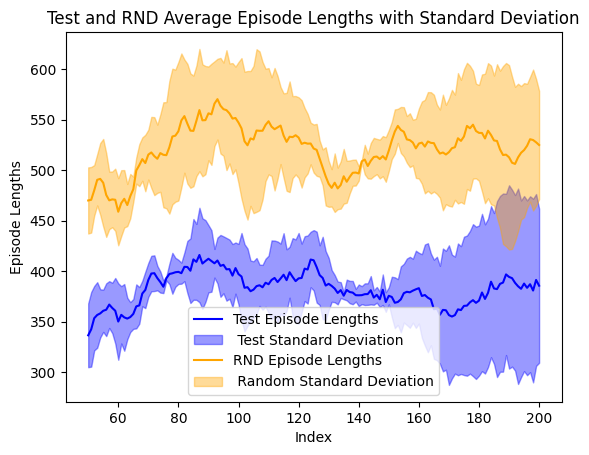

In [16]:
plot_test_and_rnd_ep_length(test_episode_lengths, random_episode_lengths, window_width= WINDOW_WIDTH)